In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [3]:
try:
    data = pd.read_csv('./dataset/train.csv', parse_dates=['date'])
except FileNotFoundError:
    print("Error: train.csv not found.")
    print("Please download the dataset from Kaggle: ")
    print("https://www.kaggle.com/competitions/store-item-demand-forecasting-challenge/data")
    exit()

In [4]:
print("--- Data Info ---")
data.info()
print("\n--- Missing Values ---")
print(data.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB

--- Missing Values ---
date     0
store    0
item     0
sales    0
dtype: int64


In [5]:
store_id = 1
item_id = 1
df = data[(data['store'] == store_id) & (data['item'] == item_id)].copy()
df = df.set_index('date')
df = df.sort_index()

In [6]:
print(f"\n--- EDA for Store {store_id}, Item {item_id} ---")
print(df.shape)


--- EDA for Store 1, Item 1 ---
(1826, 3)


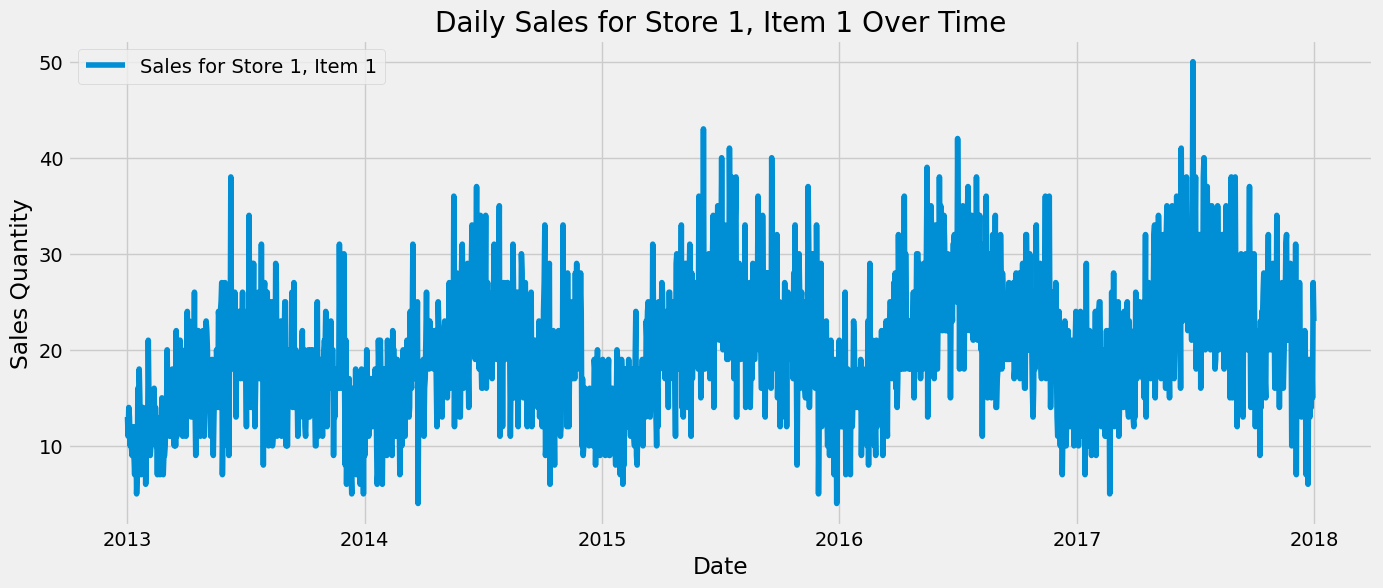

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['sales'], label=f'Sales for Store {store_id}, Item {item_id}')
plt.title(f'Daily Sales for Store {store_id}, Item {item_id} Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()

In [8]:
df['year'] = df.index.year
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek

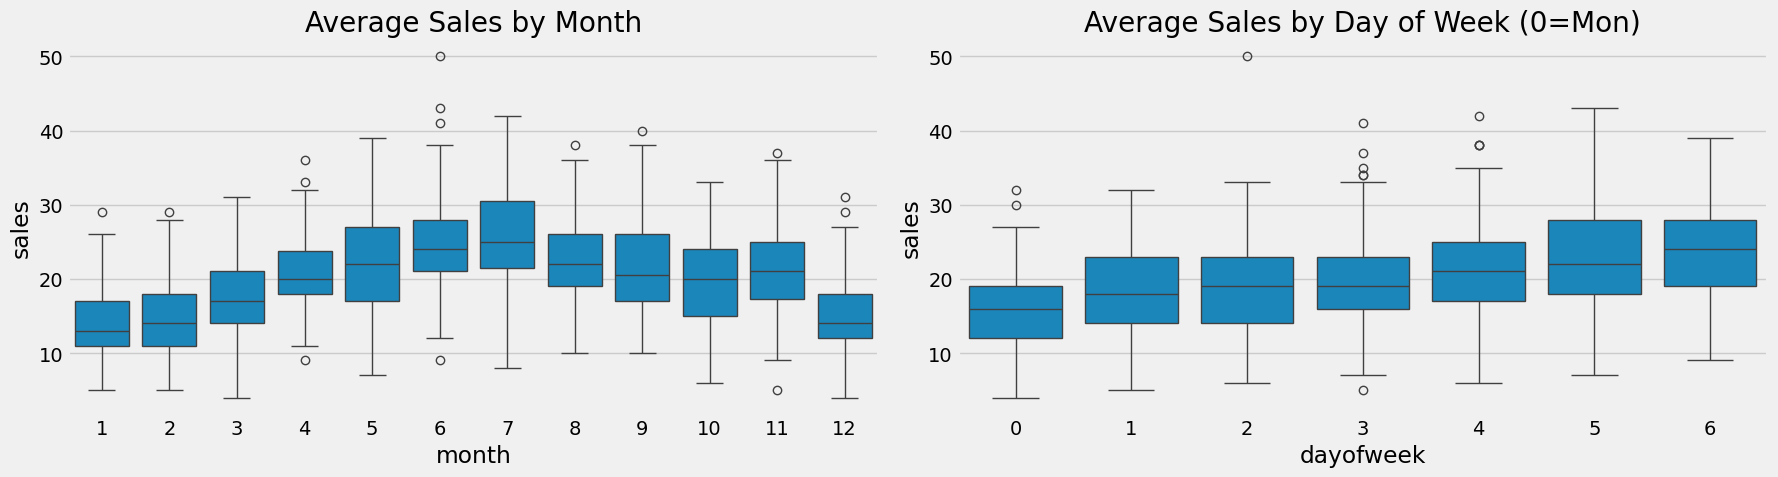

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
sns.boxplot(data=df, x='month', y='sales', ax=axes[0])
axes[0].set_title('Average Sales by Month')
sns.boxplot(data=df, x='dayofweek', y='sales', ax=axes[1])
axes[1].set_title('Average Sales by Day of Week (0=Mon)')
plt.tight_layout()
plt.show()

In [10]:
df = df.drop(['year', 'month', 'dayofweek'], axis=1)

In [11]:
print("\n--- Step 3: Feature Engineering ---")


--- Step 3: Feature Engineering ---


In [ ]:
def create_features(df_in):
    """
    Creates time series features from the date index.
    """
    df_out = df_in.copy()
    df_out['year'] = df_out.index.year
    df_out['month'] = df_out.index.month
    df_out['dayofweek'] = df_out.index.dayofweek
    df_out['dayofyear'] = df_out.index.dayofyear
    df_out['weekofyear'] = df_out.index.isocalendar().week.astype(int)
    df_out['quarter'] = df_out.index.quarter
    df_out['dayofmonth'] = df_out.index.day

    lags = [7, 14, 21, 28, 35, 42, 91, 182, 364]
    for lag in lags:
        df_out[f'sales_lag_{lag}'] = df_out['sales'].shift(lag)

    windows = [7, 14, 28, 60, 91, 182, 364]
    for window in windows:
        df_out[f'sales_roll_mean_{window}'] = df_out['sales'].shift(1).rolling(window=window, closed='left').mean()
        df_out[f'sales_roll_std_{window}'] = df_out['sales'].shift(1).rolling(window=window, closed='left').std()
        df_out[f'sales_roll_min_{window}'] = df_out['sales'].shift(1).rolling(window=window, closed='left').min()
        df_out[f'sales_roll_max_{window}'] = df_out['sales'].shift(1).rolling(window=window, closed='left').max()

    return df_out

df_featured = create_features(df.drop(['store', 'item'], axis=1))

initial_rows = df_featured.shape[0]
df_featured = df_featured.dropna()
final_rows = df_featured.shape[0]
print(f"Removed {initial_rows - final_rows} rows with NaNs after feature engineering.")

print(f"Data Shape After Feature Engineering: {df_featured.shape}")
print(f"Number of features created: {len(df_featured.columns) - 1}")

Removed 365 rows with NaNs after feature engineering.
Data Shape After Feature Engineering: (1461, 45)
Number of features created: 44


In [ ]:
TARGET = 'sales'
FEATURES = [col for col in df_featured.columns if col != TARGET]

X = df_featured[FEATURES]
y = df_featured[TARGET]

test_size_days = 180
split_date = df_featured.index.max() - pd.Timedelta(days=test_size_days)

X_train = X[X.index <= split_date]
y_train = y[y.index <= split_date]
X_test = X[X.index > split_date]
y_test = y[y.index > split_date]

print(f"Train Set: {X_train.shape}, {y_train.shape}")
print(f"Test Set : {X_test.shape}, {y_test.shape}")
print(f"Features before selection: {len(FEATURES)}")

Train Set: (1281, 44), (1281,)
Test Set : (180, 44), (180,)
Features before selection: 44


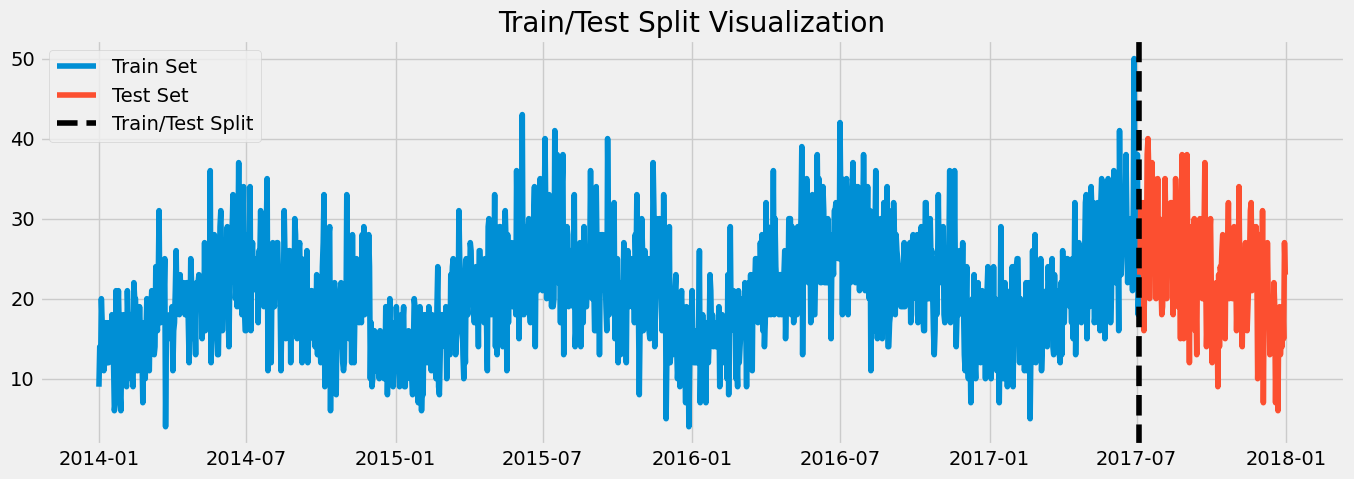

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(y_train.index, y_train, label='Train Set')
plt.plot(y_test.index, y_test, label='Test Set')
plt.axvline(split_date, color='black', linestyle='--', label='Train/Test Split')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [15]:
print("\n--- Step 4: Feature Selection ---")


--- Step 4: Feature Selection ---


Training temporary model for feature selection...

Top 20 Feature Importances:
               Feature  Importance
20  sales_roll_mean_14    0.240191
2            dayofweek    0.068179
26   sales_roll_min_28    0.058062
24  sales_roll_mean_28    0.039518
15       sales_lag_364    0.032476
4           weekofyear    0.029899
23   sales_roll_max_14    0.027457
31   sales_roll_max_60    0.027106
16   sales_roll_mean_7    0.023027
1                month    0.020571
22   sales_roll_min_14    0.018616
18    sales_roll_min_7    0.017235
11        sales_lag_35    0.015899
32  sales_roll_mean_91    0.015889
19    sales_roll_max_7    0.015080
3            dayofyear    0.015002
12        sales_lag_42    0.014572
17    sales_roll_std_7    0.014394
38  sales_roll_min_182    0.014363
25   sales_roll_std_28    0.014363


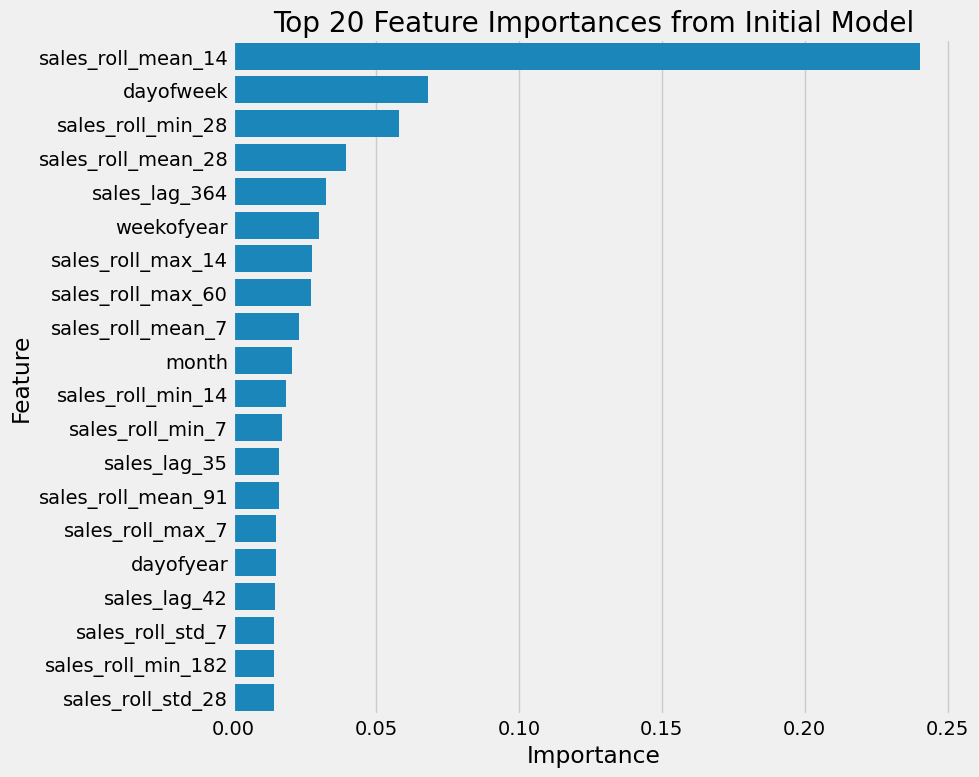

In [ ]:
selection_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training temporary model for feature selection...")
selection_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

importances = selection_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(importance_df.head(20))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from Initial Model')
plt.tight_layout()
plt.show()

In [ ]:
selector = SelectFromModel(selection_model, threshold='median', prefit=True)

print("\nSelecting features using threshold='median'...")
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]

print(f"Number of features selected: {len(selected_features)}")
print("Selected Features:", selected_features.tolist())

X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)


Selecting features using threshold='median'...
Number of features selected: 22
Selected Features: ['month', 'dayofweek', 'dayofyear', 'weekofyear', 'sales_lag_35', 'sales_lag_42', 'sales_lag_91', 'sales_lag_364', 'sales_roll_mean_7', 'sales_roll_std_7', 'sales_roll_min_7', 'sales_roll_max_7', 'sales_roll_mean_14', 'sales_roll_min_14', 'sales_roll_max_14', 'sales_roll_mean_28', 'sales_roll_std_28', 'sales_roll_min_28', 'sales_roll_max_60', 'sales_roll_mean_91', 'sales_roll_mean_182', 'sales_roll_min_182']


In [19]:
print("\n--- Step 6: Training Final XGBoost Model (with Selected Features) ---")


--- Step 6: Training Final XGBoost Model (with Selected Features) ---


In [ ]:
final_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42,
    n_jobs=-1
)

eval_set = [(X_train, y_train), (X_test, y_test)]
final_xgb_model.fit(X_train, y_train,
                    eval_set=eval_set,
                    eval_metric='rmse',
                    verbose=100)

[0]	validation_0-rmse:6.64261	validation_1-rmse:7.09546
[100]	validation_0-rmse:4.53920	validation_1-rmse:5.35160
[200]	validation_0-rmse:3.81309	validation_1-rmse:4.91139
[300]	validation_0-rmse:3.45623	validation_1-rmse:4.81884
[400]	validation_0-rmse:3.21832	validation_1-rmse:4.80585
[449]	validation_0-rmse:3.11981	validation_1-rmse:4.81274


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [21]:
print("\n--- Step 8: Evaluating Final Model on Test Set ---")


--- Step 8: Evaluating Final Model on Test Set ---



--- Final Model Evaluation Metrics (XGBoost with Feature Selection) ---
Root Mean Squared Error (RMSE): 4.8058
Mean Absolute Error (MAE):      3.9318
Mean Absolute Percentage Error (MAPE): 0.1982


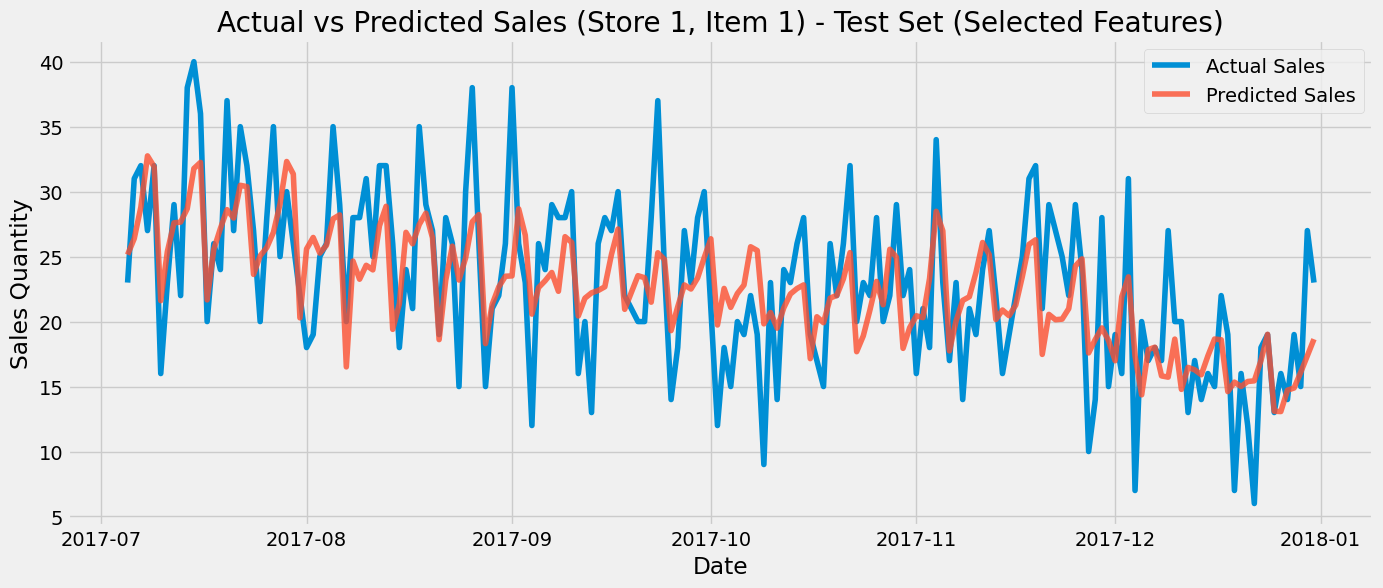

In [ ]:
y_pred = final_xgb_model.predict(X_test)

predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\n--- Final Model Evaluation Metrics (XGBoost with Feature Selection) ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

plt.figure(figsize=(15, 6))
plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual Sales')
plt.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted Sales', alpha=0.8)
plt.title(f'Actual vs Predicted Sales (Store {store_id}, Item {item_id}) - Test Set (Selected Features)')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()

<Figure size 1000x660 with 0 Axes>

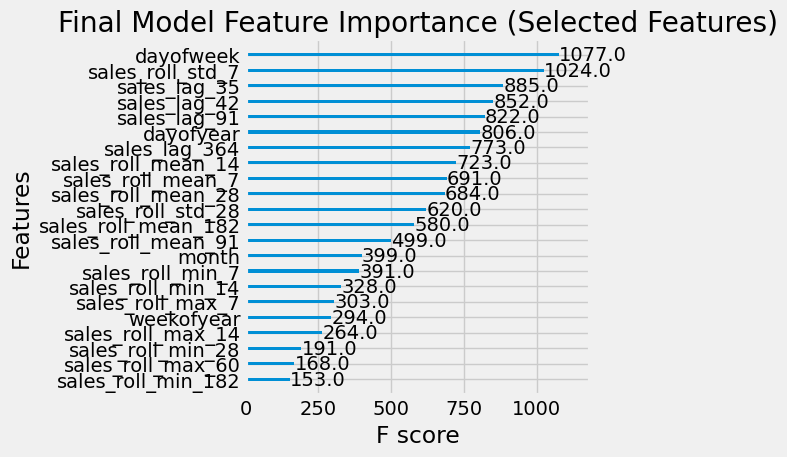


--- Process Complete ---


In [ ]:
plt.figure(figsize=(10, max(6, len(selected_features) * 0.3)))
try:
    xgb.plot_importance(final_xgb_model, max_num_features=len(selected_features))
    plt.title('Final Model Feature Importance (Selected Features)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance using xgb.plot_importance: {e}")

print("\n--- Process Complete ---")